In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

# https://blog.csdn.net/Leon_winter/article/details/86604553
# https://blog.csdn.net/qq_34116958/article/details/100039590
# pip install bayesian-optimization
from bayes_opt import BayesianOptimization 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,auc,roc_curve,accuracy_score
from sklearn.model_selection import train_test_split

import warnings  #去除警告包
warnings.filterwarnings('ignore')#去除警告

## 贝叶斯优化调参
#### pip install bayesian-optimization
#### 贝叶斯调参的主要思想是：
给定优化的目标函数(广义的函数，只需指定输入和输出即可，无需知道内部结构以及数学性质)，通过不断地添加样本点来更新目标函数的后验分布(高斯过程,直到后验分布基本贴合于真实分布）。简单的说，就是考虑了上一次参数的信息，从而更好的调整当前的参数。
#### 贝叶斯调参的步骤如下：
- 定义优化函数(rf_cv）
- 建立模型
- 定义待优化的参数
- 得到优化结果，并返回要优化的分数指标

In [2]:
# 加载训练数据
X = pd.read_csv("./processs_datas/train_process_datas_x.csv")
Y = pd.read_csv("./processs_datas/train_datas_Y.csv")

In [3]:
print(X.shape)
print(X.head())

(800000, 44)
   id  loanAmnt  term  interestRate  installment  grade  subGrade  \
0   0   35000.0     5         19.52       917.97      5        22   
1   1   18000.0     5         18.49       461.90      4        17   
2   2   12000.0     5         16.99       298.17      4        18   
3   3   11000.0     3          7.26       340.96      1         4   
4   4    3000.0     3         12.99       101.07      3        12   

   employmentTitle  employmentLength  homeOwnership  ...    n5    n6    n7  \
0            320.0                 3              2  ...   9.0   8.0   4.0   
1         219843.0                 6              0  ...   5.0   4.0   6.0   
2          31698.0                 9              0  ...   0.0  21.0   4.0   
3          46854.0                11              1  ...  16.0   4.0   7.0   
4             54.0                 0              1  ...   4.0   9.0  10.0   

     n8   n9   n10  n11  n12  n13  n14  
0  12.0  2.0   7.0  0.0  0.0  0.0  2.0  
1  10.0  4.0  13.0  0

In [4]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 44 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  int64  
 6   subGrade            800000 non-null  int64  
 7   employmentTitle     800000 non-null  float64
 8   employmentLength    800000 non-null  int64  
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  purpose             800000 non-null  int64  
 13  postCode            800000 non-null  float64
 14  regionCode          800000 non-null  int64  
 15  dti                 800000 non-nul

In [5]:
print(Y["isDefault"].value_counts())

0    640390
1    159610
Name: isDefault, dtype: int64


In [6]:
print(Y["isDefault"].shape)

(800000,)


In [7]:
# 二、数据清洗与预处理  （这里在dataprocess里面完成了）
# 删除ID字段
X.drop(['id'],axis=1,inplace=True)

# 三、获取数据的特征属性X和目标属性Y

# 四、数据分割
x_train,x_test,y_train,y_test = train_test_split(X,Y["isDefault"],test_size=0.2,random_state=11)
print(x_train.shape)
print(x_test.shape)

(640000, 43)
(160000, 43)


# 特征工程和特征选择
- 分桶
- 连续特征离散化
- 正态分布--3σ
- 异常数据检查
- 特征过滤--方差过滤、相关性检测
- 。。。。


In [8]:
#数据采样 n组  0：1 接近1：1，2：1


## 贝叶斯优化

In [9]:
"""定义优化函数"""
# lightgbm中文文档  https://lightgbm.apachecn.org/#/docs/6  
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', 
                                   objective='binary', 
                                   metric='auc',
                                   learning_rate=0.1, 
                                   n_estimators=500,
                                   num_leaves=int(num_leaves), 
                                   max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), 
                                   feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), 
                                   min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, 
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, 
                                   reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    
    val = cross_val_score(model_lgb, x_train, y_train, cv=5, scoring='roc_auc').mean()
#     val_01 =     
    return val

In [10]:
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {  
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 1.0),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

In [ ]:
"""开始优化"""
bayes_lgb.maximize()

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=80, subsample_freq=0 will be ignored. Current value: bagging_freq=80
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] bagging_fraction is set=0.63, subsample=1.0 will be ignored. Current value: bagging_fraction=0.63
[LightGBM] [Warning] bagging_freq is set=84, subsample_freq=0 will be ignored. Current value: bagging_freq=84
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] bagging_fraction is set=0.63, subsample=1.0 will be ignored. Current value: bagging_fraction=0.63
[LightGBM] [Warning] bagging_freq is set=84, subsample_freq=0 will be ignored. Current value: bagging_freq=84
[LightGBM] [Warning] feature_fraction is set=0

[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] bagging_freq is set=74, subsample_freq=0 will be ignored. Current value: bagging_freq=74
[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] bagging_freq is set=74, subsample_freq=0 will be ignored. Current value: bagging_freq=74
[LightGBM] [Warning] feature_fraction is set=0

[LightGBM] [Warning] feature_fraction is set=0.94, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] bagging_freq is set=91, subsample_freq=0 will be ignored. Current value: bagging_freq=91
[LightGBM] [Warning] feature_fraction is set=0.94, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] bagging_freq is set=91, subsample_freq=0 will be ignored. Current value: bagging_freq=91
|  10       |  0.7285   |  0.9301   |  91.05  

[LightGBM] [Warning] feature_fraction is set=0.69, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.69
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] bagging_freq is set=92, subsample_freq=0 will be ignored. Current value: bagging_freq=92
|  13       |  0.7282   |  0.7569   |  92.32    |  0.6885   |  13.78    |  0.8769   |  75.3     |  0.4799   |  29.41    |  4.962    |  2.05     |
[LightGBM] [Warning] feature_fraction is set=0.98, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.98
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM]

|  16       |  0.7282   |  0.7872   |  95.53    |  0.6838   |  4.357    |  0.6223   |  72.29    |  0.8873   |  32.19    |  3.385    |  0.138    |
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=88, subsample_freq=0 will be ignored. Current value: bagging_freq=88
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warnin

In [ ]:
"""显示优化结果"""
bayes_lgb.max

In [ ]:
params = bayes_lgb.max
params = params["params"]


In [ ]:
val = rf_cv_lgb(**params)
val

In [ ]:
# 获取参数后重新训练模型

In [8]:
# 训练lgb模型
# params ={
#     'bagging_fraction': 0.9597072852836863,
#     'bagging_freq': 96.02333163723546,
#     'feature_fraction': 0.5146686517201933,
#     'max_depth': 8.726951175253506,
#     'min_child_weight': 8.21938297729288,
#     'min_data_in_leaf': 88.7793205900251,
#     'min_split_gain': 0.2734387479280127,
#     'num_leaves': 76.42645999721336,
#     'reg_alpha': 6.25601283860137,
#     'reg_lambda': 0.31112717567529424
# }

# {'bagging_fraction': 0.8952697772299671,
#   'bagging_freq': 0.653709009526815,
#   'feature_fraction': 0.5016129456258751,
#   'max_depth': 16.164048414389743,
#   'min_child_weight': 0.6178648072920936,
#   'min_data_in_leaf': 87.42041507563499,
#   'min_split_gain': 0.9123560894591687,
#   'num_leaves': 196.56327670792092,
#   'reg_alpha': 8.258785210297255,
#   'reg_lambda': 7.277160365919464}

lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', 
                               objective='binary', 
                               metric='auc',
                               learning_rate=0.1, 
                               n_estimators=5000,
                               num_leaves=196, 
                               max_depth=16, 
                               bagging_fraction=0.89, 
                               feature_fraction=0.50,
                               bagging_freq=1, 
                               min_data_in_leaf=87,
                               min_child_weight=0.61, 
                               min_split_gain=0.91,
                               reg_lambda=0.31, 
                               reg_alpha=7.27,
                               n_jobs= 8
                              )

lgb_model.fit(x_train,y_train)


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_fraction is set=0.89, subsample=1.0 will be ignored. Current value: bagging_fraction=0.89
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.89, bagging_freq=1, feature_fraction=0.5,
               max_depth=16, metric='auc', min_child_weight=0.61,
               min_data_in_leaf=87, min_split_gain=0.91, n_estimators=5000,
               n_jobs=8, num_leaves=196, objective='binary', reg_alpha=7.27,
               reg_lambda=0.31)

In [9]:
lgb_model.score(x_train,y_train)

0.819696875

In [10]:
lgb_model.score(x_test,y_test)

0.80539375

In [11]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', 
                               objective='binary', 
                               metric='auc',
                               learning_rate=0.1, 
                               n_estimators=5000,
                               num_leaves=196, 
                               max_depth=16, 
                               bagging_fraction=0.89, 
                               feature_fraction=0.50,
                               bagging_freq=1, 
                               min_data_in_leaf=87,
                               min_child_weight=0.61, 
                               min_split_gain=0.91,
                               reg_lambda=0.31, 
                               reg_alpha=7.27,
                               n_jobs= 8
                              )
lgb_model.fit(X,Y)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_fraction is set=0.89, subsample=1.0 will be ignored. Current value: bagging_fraction=0.89
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.89, bagging_freq=1, feature_fraction=0.5,
               max_depth=16, metric='auc', min_child_weight=0.61,
               min_data_in_leaf=87, min_split_gain=0.91, n_estimators=5000,
               n_jobs=8, num_leaves=196, objective='binary', reg_alpha=7.27,
               reg_lambda=0.31)

In [12]:
print(lgb_model.score(X,Y))
datas_y_hat = lgb_model.predict(X)

0.81870125


In [13]:
print("整体准确率：{}".format(accuracy_score(Y, datas_y_hat)))

整体准确率：0.81870125


整体的AUC值：0.5696675504578137


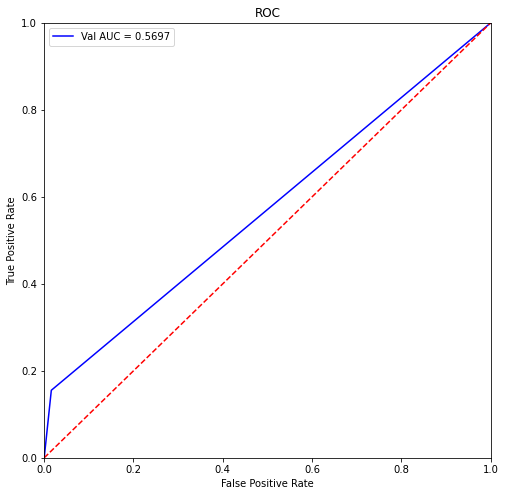

In [14]:
# 看下ROC曲线
fpr, tpr, threshold = roc_curve(Y, datas_y_hat)
roc_auc = auc(fpr, tpr)
print("整体的AUC值：{}".format(roc_auc))

"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [15]:
import joblib

save_dir_path = './model'
import os
if os.path.exists(save_dir_path):
    pass
else:
    os.makedirs(save_dir_path)

joblib.dump(lgb_model,save_dir_path+'/lgb_model.pkl')

['./model/lgb_model.pkl']